## Filtros FIR-LS con registro finito: Método de Covarianza

El objetivo del método **FIR-LS (Least Squares)** es ajustar un filtro FIR de orden $L-1$ que minimice el error entre una señal deseada $d(n)$ y una señal generada a partir de otra señal $x(n)$ filtrada por $h(n)$. La salida estimada del sistema es:

$$
\hat{d}(n) = \sum_{k=0}^{L-1} h(k) \, x(n - k)
$$

El error entre la señal deseada y la salida estimada es:

$$
e(n) = d(n) - \hat{d}(n) = d(n) - \sum_{k=0}^{L-1} h(k) \, x(n - k)
$$

El criterio de optimización es la minimización de la energía del error:

$$
\mathcal{E}(\mathbf{h}) = \sum_{n=i_0}^{i_f} |e(n)|^2
$$

Los límites $i_0$ e $i_f$ se eligen para que todas las muestras de $x(n-k)$ y $d(n)$ estén disponibles. La solución óptima del filtro FIR para minimizar el error cuadrático se obtiene resolviendo el sistema de ecuaciones normales:

$$
\frac{\partial \mathcal{E}}{\partial h(k)}
\sum_{n=i_0}^{i_f} e(n)\,\frac{\partial x^*(n)}{\partial h(k)} =
\sum_{n=i_0}^{i_f} e(n)\,x^*(n - k) = 0
$$

$$
\begin{aligned}
        \sum_{n=i_0}^{i_f}\left[ d(n) - \sum_{n=0}^{L-1}h(l)x(n-l)\right]x^*(n-k) &=0  \\
        \sum_{n=i_0}^{i_f} d(n) x^*(n-k) &= \sum_{n=0}^{L-1} h(l) \cdot \sum_{n=i_0}^{i_f} x(n-l) x^*(n-k) 
\end{aligned}
$$
$$
       \boxed{\sum_{n=i_0}^{i_f} d'(n-n_0) x^*(n-k) = \sum_{n=0}^{L-1} h(l) \cdot \sum_{n=i_0}^{i_f} x(n-l) x^*(n-k)} 
$$
Matricialmente:
$$
\mathbf{R}_x \, \mathbf{h} = \mathbf{r}_{dx}
$$
donde
$$
\mathbf{X}_{i_0} =
\begin{bmatrix}
x(i_0) & x(i_0 - 1) & \cdots & x(i_0 - L + 1) \\
x(i_0 + 1) & x(i_0) & \cdots & x(i_0 - L + 2) \\
\vdots & \vdots & \ddots & \vdots \\
x(i_f) & x(i_f - 1) & \cdots & x(i_f - L + 1)
\end{bmatrix}
\qquad \qquad \text{y}\qquad \qquad \mathbf{d}_{i_0} =
\begin{bmatrix}
d(i_0) \\
d(i_0 + 1) \\
\vdots \\
d(i_f)
\end{bmatrix}
$$
Entonces:
- $\mathbf{R}_x = \mathbf{X}_{i_0}^H \mathbf{X}_{i_0}$
- $\mathbf{r}_{dx} = \mathbf{X}_{i_0}^H \mathbf{d}_{i_0}$

El valor mínimo de la energía del error se puede expresar como:

$$
\mathcal{E}_{\min} = \|\mathbf{d}_{i_0}\|^2 - \sum_{k=0}^{L-1} h(k) \, r_{dx}^*(k) \qquad \longrightarrow \qquad \mathcal{E}_{\min} = r_d(0, 0) - \sum_{k=0}^{L-1} h(k) \, r_{dx}^*(k)
$$
donde:
$$
r_d(0, 0) = \sum_{n = i_0}^{i_f} |d(n)|^2 = \|\mathbf{d}_{i_0}\|^2
$$

Este método no impone ninguna suposición sobre los datos fuera del intervalo de observación, a diferencia del método de autocorrelación. Es por tanto más adecuado en condiciones de ventana finita, especialmente en aplicaciones prácticas como el diseño de filtros adaptativos o estimación de sistemas.


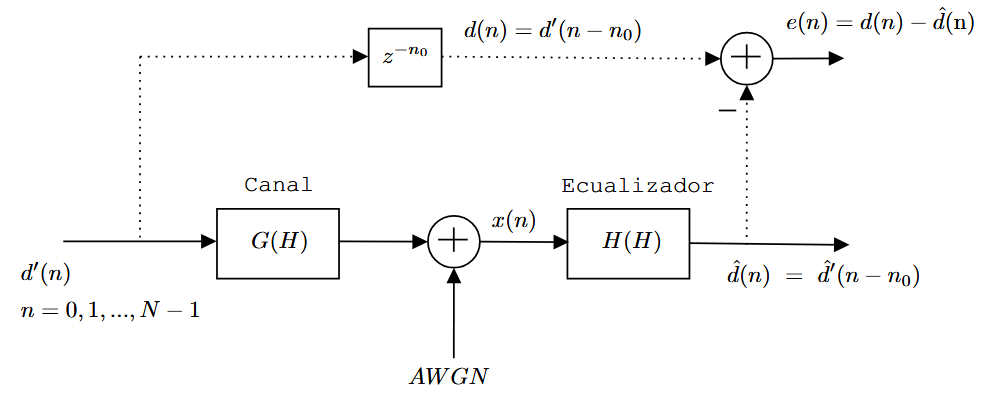

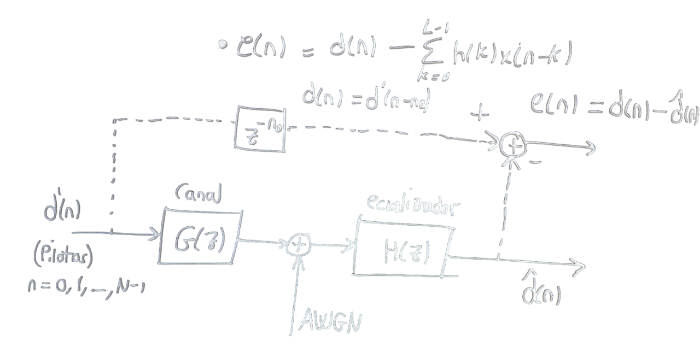

In [2]:
%reset


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import toeplitz  # comando de generacion matrices Toeplitz
from scipy.linalg import inv  # comando de inversion de matrices
from macros import *


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 1</h1>

<hr style="border: 1.5px solid orange;">

Se comprobará el funcionamiento del ecualizador para valores de retardo $n_0 = 0, 1, \dots, L-1$, obteniendo en cada caso el error cuadrático directo y el _bit error rate_ (**BER**). Dibujar en una misma gráfica el error cuadrático (promediado al número de muestras) y el BER en función del retardo $n_0$. Seleccionar el valor de $n_0$ óptimo.

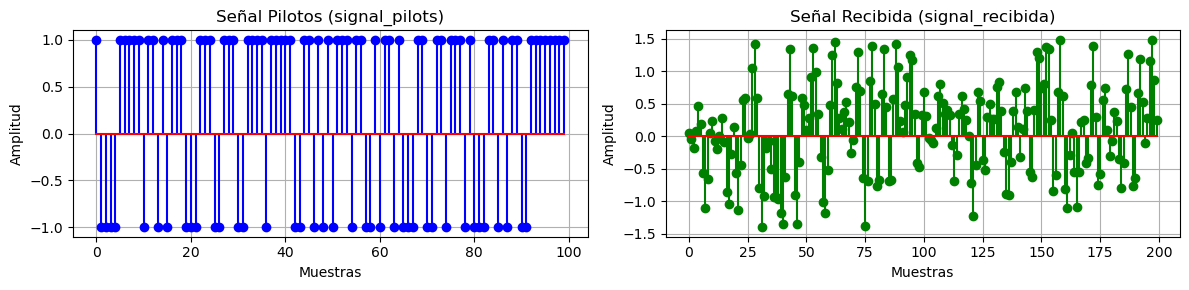

In [3]:

# Cargar los archivos .npy
signal_pilots = np.load('data/signal_pilots.npy')
signal_recibida = np.load('data/signal_recibida.npy')


#! Representación gráfica de las señales en forma discreta
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1) #? Graficar signal_pilots
plt.stem(signal_pilots, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title("Señal Pilotos (signal_pilots)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

plt.subplot(1, 2, 2) #? Graficar signal_recibida
plt.stem(signal_recibida, linefmt='g-', markerfmt='go', basefmt='r-')
plt.title("Señal Recibida (signal_recibida)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()

plt.tight_layout()
plt.show()




In [4]:

#? ====================================================================
#? Función FIR_LS_COV_method_equalizer
#? ====================================================================
def FIR_LS_COV_method_equalizer(x, d_train, L, i_0, i_f, n_0):
    """
    Calcula los coeficientes del filtro FIR-LS para ecualización mediante el método
    de covarianza. Se minimiza el error entre la señal deseada d(n) (piloto) y la salida
    del ecualizador:
    
        y(n) = ∑[k=0]^(L-1) h(k) x(n - n_0 - k)
    
    sobre el intervalo de entrenamiento definido por la señal recibida x en [i_0, i_f].
    
    Parámetros:
        x   : numpy array
              Señal recibida (por ejemplo, 200 muestras).
        d   : numpy array
              Señal piloto (deseada). Se asume que d contiene la secuencia piloto en el orden
              adecuado y de tamaño M = i_f - i_0 + 1 (por ejemplo, 100 muestras).
        L   : int
              Longitud del filtro FIR (número de coeficientes, L = 10).
        i_0 : int
              Índice inicial del intervalo de entrenamiento en x (por ejemplo, 50).
        i_f : int
              Índice final del intervalo de entrenamiento en x (por ejemplo, 149).
        n_0 : int
              Retardo que compensa el desfase entre la señal x y la secuencia piloto d.
    
    Retorna:
        h    : numpy array
               Vector de coeficientes del filtro FIR (longitud L).
        E_min: float
               Energía mínima del error calculada sobre el intervalo de entrenamiento.
    """
    M = i_f - i_0 + 1     # Número de muestras en el intervalo de entrenamiento (M)

    # Inicializar la matriz de regresores X (dimensión M x L)
    X = np.zeros((M, L), dtype=x.dtype)

    #? Cada fila i corresponde a la observación para n = i_0 + i y contiene:
    #! [ x(n - n_0), x(n - n_0 - 1), ..., x(n - n_0 - L + 1) ]
#     for i in range(M):
#         n = i_0 + i                 #        # + 1 para que llegue hasta n-n_0
#         X[i, :] = x[n + n_0 - L + 1 : n + n_0 + 1][::-1]         # Invertir el segmento para que el primer elemento sea x(n - n_0)

    # calculo la primera fila de la matriz toeplitz
    fila = x[i_0 + n_0 - L + 1 : i_0 + n_0 + 1][::-1] 
    columna = x[i_0 + n_0 : i_f + n_0 + 1] # columna de la matriz toeplitz
      
    X = toeplitz(columna, fila)

    #? Calcular las matrices
    R_x = X.conj().T @ X # R_x = X^H X 
    r_dx = X.conj().T @ d_train # r_dx = X^H d_train

    #? Resolver las ecuaciones normales: R_x * h = r_dx
    h = inv(R_x) @ r_dx

    #? Calcular la energía mínima del error:
    # E_min = ||d_train||^2 - h^H r_dx
    E_min = np.sum(np.abs(d_train)**2) - np.real(np.vdot(h, r_dx))

    return h, E_min

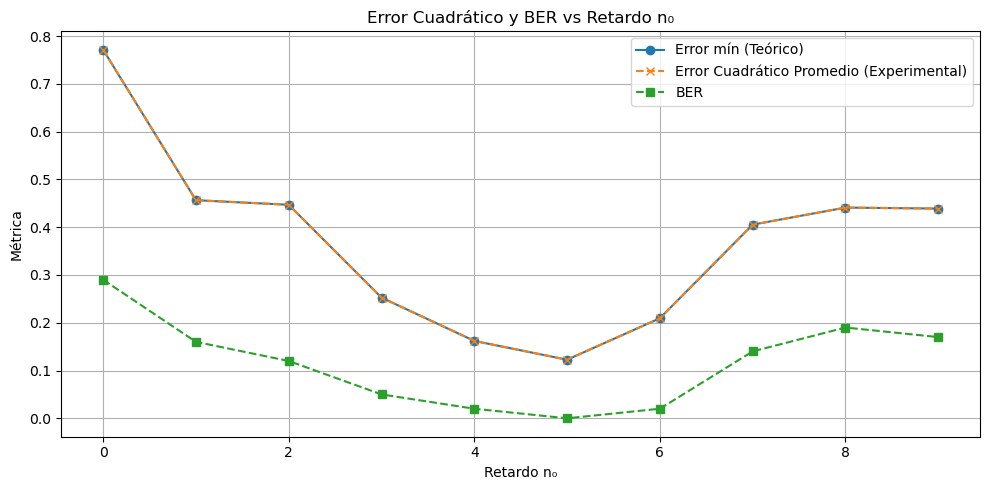

Retardo óptimo (n₀) = 5


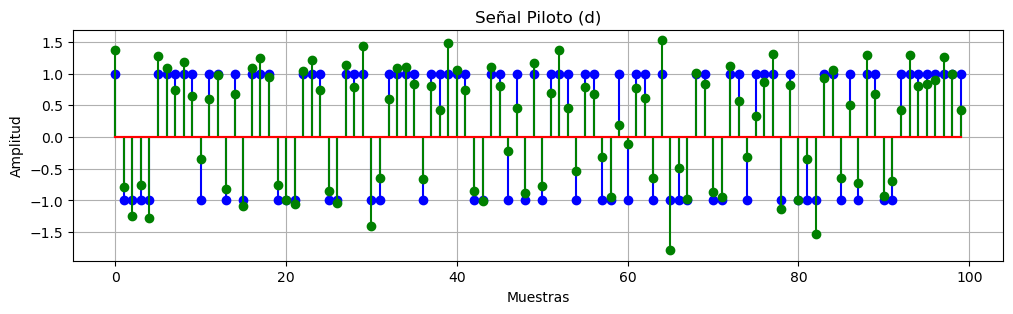

In [25]:
# Cargar las señales desde los archivos .npy
x = np.load('data/signal_recibida.npy')  # Señal recibida (ej. 200 muestras)
d = np.load('data/signal_pilots.npy')     # Señal piloto (ej. 100 muestras)

# Parámetros del filtro y del intervalo de entrenamiento
L = 10          # Filtro FIR de 15 coeficientes
i_0 = 50        # Índice inicial donde está la secuencia piloto en x
i_f = 149       # Índice final del segmento piloto en x
M = i_f - i_0 + 1  # Número de muestras de entrenamiento (ej. 100)

# Se asume que d debe contener la secuencia piloto en el mismo orden y longitud M.
if len(d) != M:
    print("Error: La longitud de d (señal piloto) no coincide con el intervalo de x.")

# Definir los retardos a probar: de 0 a L-1
n0_values = np.arange(L)

# Inicializar listas para almacenar las métricas para cada retardo n₀
error_min = []  # Error cuadrático promedio de la fórmula
error_exp = []  # Error cuadrático promedio
BER_exp  = []   # Bit Error Rate (BER)
                    
#! Iterar sobre cada valor de retardo n₀
for n0 in n0_values:
        # Calcular el filtro FIR para el retardo actual n₀
        h, E_min = FIR_LS_COV_method_equalizer(x, d, L, i_0, i_f, n0)
        
        #? Calcular el error cuadrático promedio en el intervalo
        error_min.append(E_min / M)    
        
        #? Estimar BER: calcular la señal ecualizada y comparar con la señal piloto
        # Aplicar el filtro a la señal recibida utilizando convolución
        x_eq = np.convolve(x, h, mode='full')[:len(x)]     # Se utiliza 'full' y se trunca para mantener la longitud de x

        # Estimar la señal piloto con la compensación del retardo
        d_est = x_eq[i_0 + n0 : i_f + n0 + 1]           # Se extrae el segmento correspondiente del ecualizador
        
        # Convertir a bits para una señal BPSK: se usa np.sign para mapear a +1 / -1
        bits_est = np.sign(d_est)
        
        # Calcular el BER como la proporción de bits erróneos
        ber = np.mean(bits_est != d)
        BER_exp.append(ber)

        #? Calcular el error cuadrático promedio de la señal ecualizada
        error_exp.append(np.mean((d - d_est)**2))  # Error cuadrático promedio

#? ====================================================================
#? Gráfica de resultados: Error cuadrático y BER vs retardo n₀
#? ====================================================================
plt.figure(figsize=(10, 5))
plt.plot(n0_values, error_min, 'o-', label='Error mín (Teórico)')
plt.plot(n0_values, error_exp, 'x--', label='Error Cuadrático Promedio (Experimental)')
plt.plot(n0_values, BER_exp, 's--', label='BER')
plt.xlabel('Retardo n₀')
plt.ylabel('Métrica')
plt.title('Error Cuadrático y BER vs Retardo n₀')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#! Seleccionar el retardo óptimo como aquel que minimiza el error cuadrático promedio
opt_index = np.nanargmin(error_exp)
n0_opt = n0_values[opt_index]
print(f"Retardo óptimo (n₀) = {n0_opt}")

#? ====================================================================
#? Representar la señal piloto junto con la señal ecualizada
#? ====================================================================

h, E_min = FIR_LS_COV_method_equalizer(x, d, L, i_0, i_f, n0_opt)
x_eq = np.convolve(x, h, mode='full')[:len(x)]
d_est = x_eq[i_0 + n0_opt : i_f + n0_opt + 1] 


plt.figure(figsize=(12, 3))
plt.stem(d, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.stem(d_est, linefmt='g-', markerfmt='go', basefmt='r-')
plt.title("Señal Piloto (d)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()





<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 2</h1>

<hr style="border: 1.5px solid orange;">

Sabiendo que el canal $G(z)$ es IIR de orden 3 y que tiene los siguientes coeficientes en su numerador (coeficientes **b**) y su denominador (coeficientes **a**):

```text
b = [0.06366198, -0.12349588, 0.05611536, 0.23689969]
a = [1.0, -2.93711362, 3.06181384, -1.15303739, 0.28529261]
```

Razonar si sería viable la ecualización empleando el filtro inverso $G^{-1}(z)$.

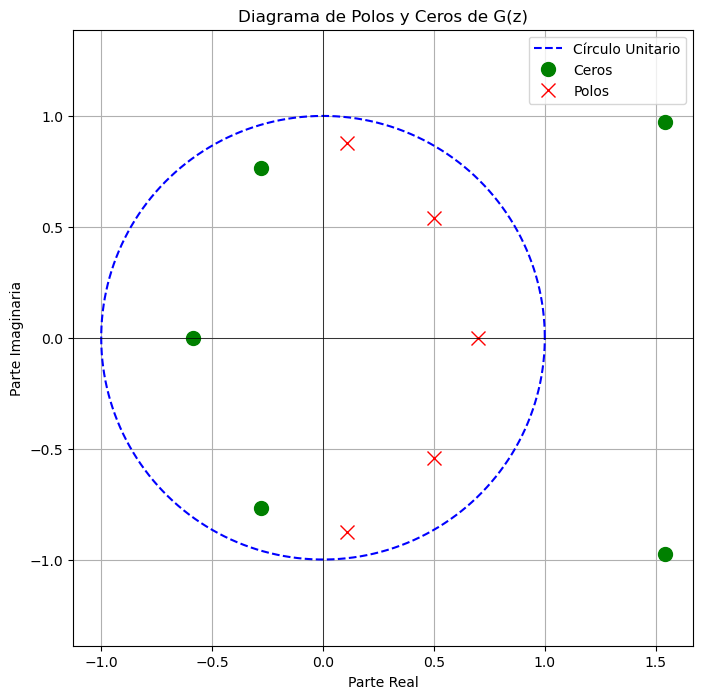

In [6]:

# !! DEFINICIÓN DEL CANAL G(z) !!
# Coeficientes del numerador (b) y denominador (a) del canal IIR de orden 5
b = np.array([0.06366198, -0.12349588, 0.05051366, 0.07243651, 0.13305393, 0.08259216])
a = np.array([1.0, -1.91931932, 2.39480009, -1.97724845, 1.05217674, -0.29576503])


# !! CALCULO DE CEROS Y POLOS DE G(z) !!
# La función tf2zpk convierte los coeficientes en ceros, polos y ganancia.
zeros, poles, k = signal.tf2zpk(b, a)


# !! DIAGRAMA DE POLOS Y CEROS !!
plt.figure(figsize=(8, 8))
# Dibuja el círculo unitario para referencia
theta = np.linspace(0, 2 * np.pi, 400)  
plt.plot(np.cos(theta), np.sin(theta), 'b--', label='Círculo Unitario')
# Plotea los ceros en verde (círculos) y los polos en rojo (cruces)
plt.plot(np.real(zeros), np.imag(zeros), 'go', markersize=10, label='Ceros')
plt.plot(np.real(poles), np.imag(poles), 'rx', markersize=10, label='Polos')
# Configuración del gráfico
plt.title('Diagrama de Polos y Ceros de G(z)')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.grid(True)
plt.legend()
plt.axis('equal')  # Asegura que el eje x e y tengan la misma escala
plt.show()


# # !! RESPUESTA AL IMPULSO DEL FILTRO G(z) !!
# # Generar una señal delta (impulso unitario)
# impulse = np.zeros(100)  # Longitud de la respuesta al impulso
# impulse[0] = 1  # Impulso unitario en la primera posición

# # Calcular la respuesta al impulso usando lfilter
# impulse_response = signal.lfilter(b, a, impulse)

# # Graficar la respuesta al impulso
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.stem(impulse_response, linefmt='b-', markerfmt='bo', basefmt='r-')
# plt.title('Respuesta al Impulso del Filtro G(z)')
# plt.xlabel('Muestras'), plt.ylabel('Amplitud')
# plt.xlim(0, 10)  # Limitar el eje x para ver mejor la respuesta
# plt.grid()
# plt.show()

# plt.subplot(1, 2, 2)
# plt.stem(h, 'o-', label='Coeficientes del Filtro FIR')



Para que la ecualización mediante un filtro inverso sea viable, es necesario que G(z) sea mínimo fase. En caso contrario, invertir el canal generaría un filtro con polos fuera del círculo unitario (inestable) y potencialmente amplificaría el ruido. En este caso, tenemos 2 ceros fuera del círculo unidad lo que para "cancelarlos" el filtro inverso debería de poner un polo en el mismo sitio. Puesto que tendríamos un polo fuera del círculo unidad, el resultado es un filtro inverso inestable.

Por tanto, teóricamente no puedo obtener un filtro estable invirtiendo el canal. Entonces ¿Cómo es que lo hemos obtenido con mínimos cuadrados usando el método de la covarianza? La respuesta es simple: es un filtro con una respuesta al impulso capada. Por tanto, realizable.

<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">ACTIVIDAD 3</h1>

<hr style="border: 1.5px solid orange;">

Para el retardo óptimo, dibujar las respuestas en frecuencia (magnitud y fase) del canal, del ecualizador, y del conjunto (cascada) canal + ecualizador.

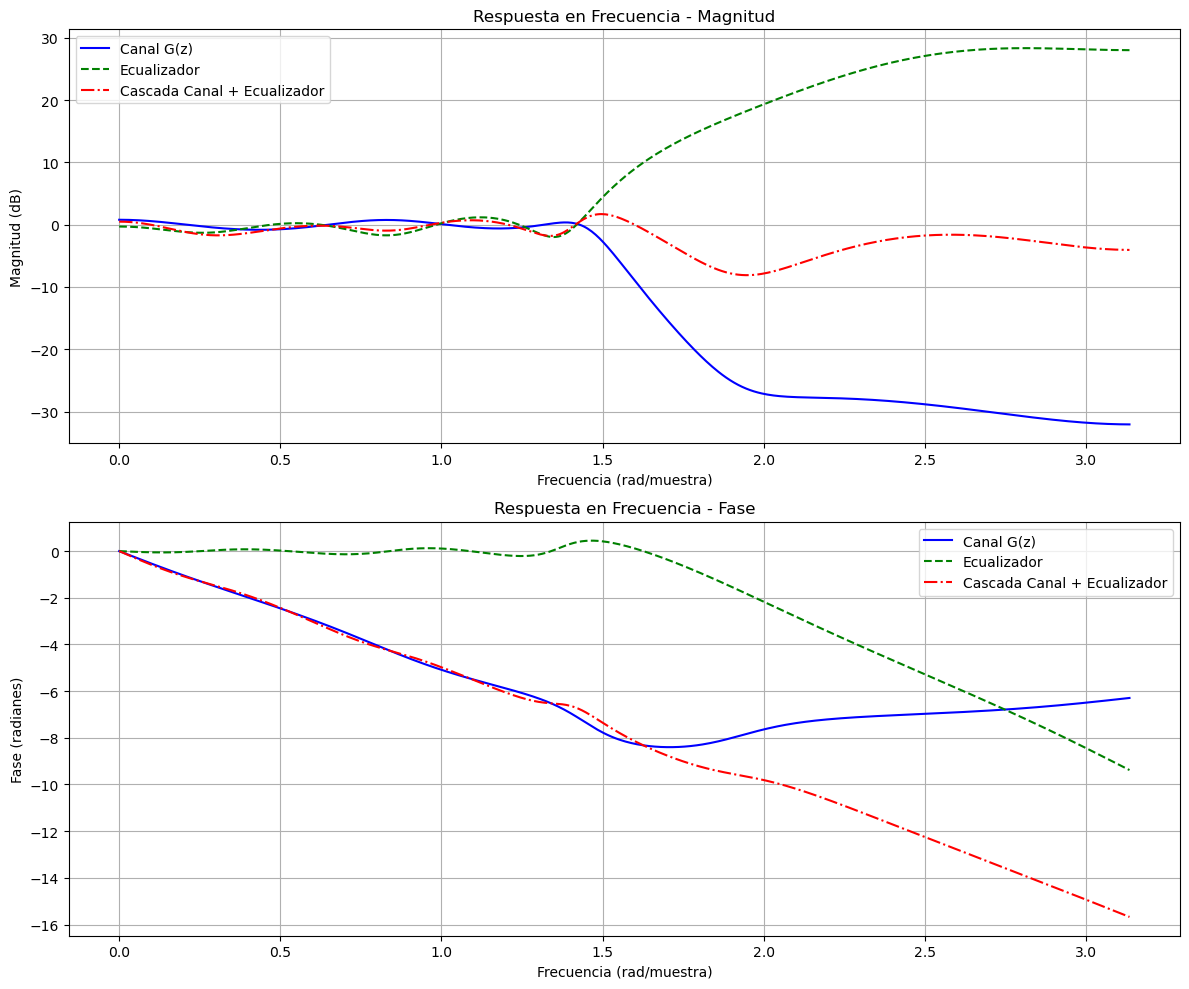

[-0.22711149  0.59352128 -0.5389747  -0.14133624  1.76950481 -0.75079522
  0.30594967 -0.01673673  0.01146441 -0.04215919]


In [ ]:


#? =============================================================================
#? Parámetros conocidos de la práctica y función de ecualización
#? =============================================================================
# Se asume que los siguientes parámetros ya han sido definidos previamente:
# x       : Señal recibida (ej. 200 muestras)
# d       : Señal piloto (ej. 100 muestras)
# L       : Longitud del filtro FIR
# i_0, i_f: Índices que definen el intervalo de entrenamiento en x
# n0_opt  : Retardo óptimo obtenido en el Ejercicio 1 (por ejemplo, a partir del análisis de error y BER)

# Calcular el ecualizador óptimo para el retardo n0_opt
h_opt, E_min_opt = FIR_LS_COV_method_equalizer(x, d, L, i_0, i_f, n0_opt)

#* Respuesta en frecuencia del Canal G(z)
w_channel, H_channel = signal.freqz(b, a, worN=512)  # worN define el número de puntos de la respuesta

#* Respuesta en frecuencia del Ecualizador
# El ecualizador es un filtro FIR cuyo denominador es 1.
w_eq, H_eq = signal.freqz(h_opt, worN=512)

#* Respuesta en frecuencia de la Cascada (Canal + Ecualizador)
# La respuesta total de la cascada es el producto de las respuestas individuales.
H_cascade = H_channel * H_eq

#* Gráficos: Magnitud y Fase de las Respuestas en Frecuencia
plt.figure(figsize=(12, 10))

# ---- Gráfico de Magnitud (en dB) ----
plt.subplot(2, 1, 1)
plt.plot(w_channel, 20 * np.log10(np.abs(H_channel)), 'b-', label='Canal G(z)')
plt.plot(w_eq, 20 * np.log10(np.abs(H_eq)), 'g--', label='Ecualizador')
plt.plot(w_channel, 20 * np.log10(np.abs(H_cascade)), 'r-.', label='Cascada Canal + Ecualizador')
plt.title('Respuesta en Frecuencia - Magnitud')
plt.xlabel('Frecuencia (rad/muestra)')
plt.ylabel('Magnitud (dB)')
plt.legend()
plt.grid(True)

# ---- Gráfico de Fase (en radianes) ----
plt.subplot(2, 1, 2)
plt.plot(w_channel, np.unwrap(np.angle(H_channel)), 'b-', label='Canal G(z)')
plt.plot(w_eq, np.unwrap(np.angle(H_eq)), 'g--', label='Ecualizador')
plt.plot(w_channel, np.unwrap(np.angle(H_cascade)), 'r-.', label='Cascada Canal + Ecualizador')
plt.title('Respuesta en Frecuencia - Fase')
plt.xlabel('Frecuencia (rad/muestra)')
plt.ylabel('Fase (radianes)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




## Análisis de la respuesta en frecuencia

La **respuesta del canal (G(z))** evidencia la presencia de atenuaciones notables a ciertas frecuencias (notches) y una caída pronunciada del nivel de magnitud a partir de aproximadamente 2 rad/muestra. Esto sugiere que el canal introduce distorsión de amplitud y fase, lo cual dificulta la transmisión de la señal en la banda afectada.

Al diseñar el **ecualizador FIR** y entrenarlo con la secuencia piloto, se observa que su respuesta compensa los picos de atenuación del canal. La función del ecualizador es “rellenar” esas caídas (o atenuaciones) y, al mismo tiempo, ajustar la fase, de modo que la salida del sistema (canal + ecualizador) presente una magnitud mucho más uniforme. Esto se aprecia claramente en la **respuesta en frecuencia del conjunto**, donde las irregularidades se han suavizado de forma significativa en comparación con la del canal solo.

Aunque no se logra una respuesta completamente plana —debido a la longitud finita del ecualizador y la naturaleza IIR del canal— se obtiene una mejora considerable de la banda de paso. En la **fase**, la suma de los retardos aporta una corrección adicional que ayuda a alinear la señal y reducir la interferencia entre símbolos.

En términos prácticos, **el ecualizador FIR-LS** cumple su objetivo de reducir la distorsión que introduce el canal y, por consiguiente, mejorar la detección de los símbolos BPSK en el receptor. El resultado visible en la respuesta en frecuencia corrobora una **significativa atenuación** de los efectos del canal y se traduce en un menor error de bit (BER) en la recuperación de la señal. Por tanto, para este escenario de práctica, **el filtro ecualizador diseñado permite una corrección eficaz de las distorsiones**, demostrando la validez y utilidad del método LS de covarianza con un retardo óptimo determinado empíricamente.
